In [1]:
import time
import numpy
import pandas
import requests
import ensembl_rest

In [11]:
def ac_to_entry(ac: str):
    entry = requests.get('https://www.uniprot.org/uploadlists', 
                         params={'from': 'ACC+ID', 'to': 'ACC', 
                                 'format': 'tab',
                                 'columns': 'id,entry_name', 
                                 'query': ac})
    try:
        entry = entry.text.split('\n')[1].split('\t')[1]
    except IndexError:
        entry = None
        
    return entry

def ac_to_ensembl(ac: str):
    ensembl_mapping = ensembl_rest.xref_external(species='human', symbol=ac)
    
    ensg = [i['id'] for i in ensembl_mapping if i['type'] == 'gene']
    
    if not ensg:
        ensg = None
    else:
        ensg = ensg[0]
    
    enst = [i['id'] for i in ensembl_mapping if i['type'] == 'transcript']
    
    if not enst:
        enst = None
    
    return ensg, enst

def ensg_to_gene(ensg: str):
    gene_name = ensembl_rest.lookup(ensg).get('display_name')
    
    return gene_name

def enst_info(enst: list):
    trs_name = []
    length_bp = []
    ensp = []
    length_aa = []
    uniprot_iso = []
    
    for trs in enst:
        trs_info = ensembl_rest.lookup(trs, params={'expand': True})

        trs_name.append(trs_info.get('display_name'))

        length_bp.append(sum([i['end'] - i['start'] + 1 for i in trs_info['Exon']\
                              if i['object_type'] == 'Exon']))

        ensp.append(trs_info.get('Translation').get('id'))

        length_aa.append(trs_info.get('Translation').get('length'))

        iso = ensembl_rest.xref_id(trs_info.get('Translation').get('id'))

        if any([(i['dbname'] == 'Uniprot_isoform') for i in iso]):
            iso = [i['primary_id'] for i in iso if (i['dbname'] == 'Uniprot_isoform')][0]
        elif any([(i['dbname'] == 'Uniprot/SWISSPROT') for i in iso]):
            iso = [i['primary_id'] for i in iso if i['dbname'] == 'Uniprot/SWISSPROT'][0]
        else:
            iso = None

        uniprot_iso.append(iso)
        
    return trs_name, length_bp, ensp, length_aa, uniprot_iso

In [9]:
with open('nextprot_050222_missing_pe2_090422.txt') as f:
    ac_list = f.read().splitlines()

In [10]:
ac_info = []
    
for i, ac in enumerate(ac_list):
    entry = ac_to_entry(ac)

    ensg, enst = ac_to_ensembl(ac)

    if not (ensg and enst):
        continue

    gene_name = ensg_to_gene(ensg)

    trs_name, length_bp, ensp, length_aa, uniprot_iso = enst_info(enst)

    for j in range(len(enst)):
        ac_info.append([ac, entry, ensg, gene_name, enst[j], trs_name[j],
                        length_bp[j], ensp[j], length_aa[j], uniprot_iso[j]])
    
    print(f'Done {i+1} out of {len(ac_list)} ACs', end='\r')
    
    # Sleep 5 seconds after every hundred ACs to not overload services
    if i % 100 == 0:
        time.sleep(5)
    
result = pandas.DataFrame(columns=['entry', 'entry_name', 'ensg_id', 'gene_name', 'enst_id',
                                   'transcript_name', 'length_bp', 'ensp_id',
                                   'length_aa', 'uniprot_isoform'],
                          data=ac_info)
        
subcols = result.columns.to_list()
subcols.pop(-2)
subcols += ['length_aa']

result = result[subcols]

result.to_excel('missing_to_ensembl_110422.xlsx', index=False)

In [12]:
result

,entry,entry_name,ensg_id,gene_name,enst_id,transcript_name,length_bp,ensp_id,uniprot_isoform,length_aa
0,A0A075B6N3,TVBX1_HUMAN,ENSG00000211750,TRBV24-1,ENST00000390397,TRBV24-1-201,381,ENSP00000374920,A0A075B6N3,115
1,A0A075B6N4,TVBY1_HUMAN,ENSG00000282499,TRBV25-1,ENST00000390398,TRBV25-1-202,381,ENSP00000374921,A0A075B6N4,114
2,A0A075B6T7,TVA6_HUMAN,ENSG00000211780,TRAV6,ENST00000390428,TRAV6-201,404,ENSP00000438290,A0A075B6T7,132
3,A0A075B6U4,TVA7_HUMAN,ENSG00000211781,TRAV7,ENST00000390429,TRAV7-201,337,ENSP00000443297,A0A075B6U4,112
4,A0A075B6V5,TVA36_HUMAN,ENSG00000211815,TRAV36DV7,ENST00000390463,TRAV36DV7-201,356,ENSP00000450804,A0A075B6V5,113
...,...,...,...,...,...,...,...,...,...,...
1519,Q9Y5P0,O51B4_HUMAN,ENSG00000183251,OR51B4,ENST00000380224,OR51B4-201,933,ENSP00000369573,Q9Y5P0,310
1520,Q9Y6U7,RN215_HUMAN,ENSG00000099999,RNF215,ENST00000382363,RNF215-203,2011,ENSP00000371800,Q9Y6U7,377
1521,S4R3P1,HMN13_HUMAN,ENSG00000270394,MTRNR2L13,ENST00000604093,MTRNR2L13-201,1445,ENSP00000474570,S4R3P1,24
1522,S4R3Y5,HMN11_HUMAN,ENSG00000270188,MTRNR2L11,ENST00000604646,MTRNR2L11-201,1552,ENSP00000474861,S4R3Y5,24


<AxesSubplot:>

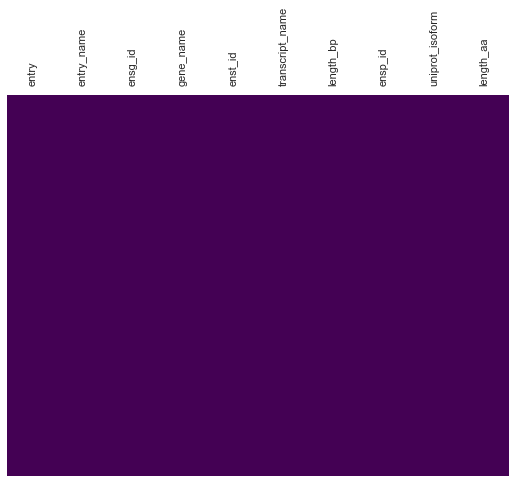

In [14]:
import seaborn
import matplotlib.pyplot as plt

seaborn.set(rc={'figure.figsize': (9,7), 
                'xtick.labeltop': True,
                'xtick.labelbottom': False})

seaborn.heatmap(result.isnull(), 
                yticklabels=False, 
                cbar=False, 
                cmap='viridis')
#plt.savefig(, dpi=300, bbox_inches='tight')

In [208]:
result.to_excel('missings_to_ensembl_full_110422.xlsx', index=False)

In [26]:
unmapped = list(set(ac_list).difference(set(result.entry.unique())))
unmapped.sort()

with open('missing_ensembl_unmapped.txt', 'w') as f:
    for i in unmapped:
        f.write(f'{i}\n')

In [25]:
len(unmapped)

231

In [245]:
hek = pandas.read_csv('hpa_expression_transcript_cellline_100422.tsv', sep='\t')

In [248]:
hek['HEK293'] = numpy.mean([hek['TPM.HEK 293.9'].to_numpy(), hek['TPM.HEK 293.10'].to_numpy()], axis=0)

In [249]:
hek['HELA'] = numpy.mean([hek['TPM.HeLa.13'].to_numpy(), hek['TPM.HeLa.14'].to_numpy()], axis=0)

In [250]:
hek['HEPG2'] = numpy.mean([hek['TPM.Hep G2.15'].to_numpy(), hek['TPM.Hep G2.16'].to_numpy()], axis=0)

In [247]:
hek['HACAT'] = numpy.mean([hek['TPM.HaCaT.143'].to_numpy(), hek['TPM.HaCaT.144'].to_numpy()], axis=0)

In [ ]:
hek

In [251]:
hek = hek[['ensgid', 'enstid', 'HACAT', 'HEK293', 'HELA', 'HEPG2']]

In [268]:
result['hacat_tpm'] = result['enst_id'].map(hek.set_index('enstid')['HACAT'])

In [269]:
result['hek293_tpm'] = result['enst_id'].map(hek.set_index('enstid')['HEK293'])

In [270]:
result['hela_tpm'] = result['enst_id'].map(hek.set_index('enstid')['HELA'])

In [271]:
result['hepg2_tpm'] = result['enst_id'].map(hek.set_index('enstid')['HEPG2'])

In [265]:
result = result[~(result[['hek293_tpm', 'hela_tpm', 'hepg2_tpm', 'hacat_tpm']]==0).all(axis=1)]

In [276]:
result.to_excel('missing_to_ensembl_expression_110422.xlsx', index=False)

In [272]:
result[result['entry']=='Q5BJE1']

,entry,entry_name,ensg_id,gene_name,enst_id,transcript_name,length_bp,ensp_id,uniprot_isoform,length_aa,hacat_tpm,hek293_tpm,hela_tpm,hepg2_tpm


In [234]:
result = result.replace({None: numpy.nan})

In [237]:
result = result.dropna()

<AxesSubplot:>

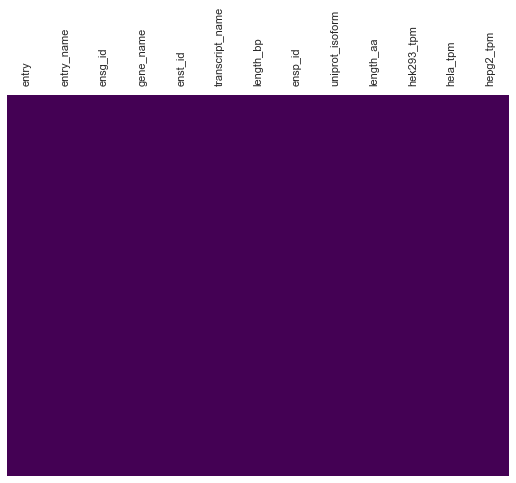

In [236]:
import seaborn
import matplotlib.pyplot as plt

seaborn.set(rc={'figure.figsize': (9,7), 
                'xtick.labeltop': True,
                'xtick.labelbottom': False})

seaborn.heatmap(result.isnull(), 
                yticklabels=False, 
                cbar=False, 
                cmap='viridis')

In [238]:
result

,entry,entry_name,ensg_id,gene_name,enst_id,transcript_name,length_bp,ensp_id,uniprot_isoform,length_aa,hek293_tpm,hela_tpm,hepg2_tpm
6,A0A075B6X5,TVA18_HUMAN,ENSG00000211798,TRAV18,ENST00000390446,TRAV18-201,440,ENSP00000451574,A0A075B6X5,111,0.284602,0.000000,0.000000
17,A0A087WVF3,TBC3D_HUMAN,ENSG00000274419,TBC1D3D,ENST00000616101,TBC1D3D-201,2116,ENSP00000478426,A0A087WVF3,549,0.000000,5.244715,0.000000
18,A0A087WXS9,TBC3I_HUMAN,ENSG00000274933,TBC1D3I,ENST00000621034,TBC1D3I-203,1790,ENSP00000481258,A0A087WXS9,549,0.000000,0.054310,0.069786
19,A0A087WXS9,TBC3I_HUMAN,ENSG00000274933,TBC1D3I,ENST00000619234,TBC1D3I-205,2122,ENSP00000478225,A0A087WXS9,549,0.000000,0.029698,0.000000
20,A0A087WXS9,TBC3I_HUMAN,ENSG00000274933,TBC1D3I,ENST00000618421,TBC1D3I-207,1790,ENSP00000478802,A0A087WXS9,549,0.000000,0.054310,0.069786
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399,Q9Y5P0,O51B4_HUMAN,ENSG00000183251,OR51B4,ENST00000380224,OR51B4-201,933,ENSP00000369573,Q9Y5P0,310,0.000000,0.070392,0.401195
400,Q9Y6U7,RN215_HUMAN,ENSG00000099999,RNF215,ENST00000382363,RNF215-203,2011,ENSP00000371800,Q9Y6U7,377,4.730035,2.556010,1.700035
401,S4R3P1,HMN13_HUMAN,ENSG00000270394,MTRNR2L13,ENST00000604093,MTRNR2L13-201,1445,ENSP00000474570,S4R3P1,24,0.096318,2.257853,1.248775
402,S4R3Y5,HMN11_HUMAN,ENSG00000270188,MTRNR2L11,ENST00000604646,MTRNR2L11-201,1552,ENSP00000474861,S4R3Y5,24,36.966950,156.884600,102.816000


In [243]:
hek['HEK293'].describe()

count    196722.000000
mean          5.083316
std          85.759005
min           0.000000
25%           0.000000
50%           0.030854
75%           0.918383
max        9937.880000
Name: HEK293, dtype: float64

In [275]:
'Q0P6D2' in ac_list

False

In [21]:
missing = pandas.read_excel('missing_to_ensembl_expression_110422.xlsx')

In [22]:
entries = missing[(missing['length_aa'] >= 200.0) & (missing['hek293_tpm'] >= 4.0)]['entry']

In [23]:
missing = missing[missing['entry'].isin(entries)]

In [24]:
missing = missing[missing.columns[:-4].to_list()+['hek293_tpm']]

In [26]:
missing.to_excel('missing_ensembl_hek_select.xlsx', index=False)

In [1]:
set().union([1,2,3])

{1, 2, 3}